In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import KBinsDiscretizer, StandardScaler, OneHotEncoder, OrdinalEncoder, MultiLabelBinarizer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy import stats

In [2]:
# Load the dataset
df = pd.read_csv('student_dataset.csv')

In [3]:
# Step 1: Data Cleaning
# Handle duplicates
df = df.drop_duplicates()

# Check for and handle missing values
df = df.dropna(subset=['Last_Active_Date', 'Engagement_Level'])
df['Course_Ratings'].fillna(df['Course_Ratings'].mean(), inplace=True)
df['Preferred_Learning_Style'].fillna(df['Preferred_Learning_Style'].mode()[0], inplace=True)

# Standardize text-based columns
df['Current_Skills'] = df['Current_Skills'].str.lower().apply(lambda x: x.strip('[]').split(', '))
df['Engagement_Level'] = df['Engagement_Level'].str.lower()
# Convert Last_Active_Date to numeric (days since last active)
df['Days_Since_Last_Active'] = (pd.to_datetime('today') - pd.to_datetime(df['Last_Active_Date'])).dt.days
df.drop(columns=['Last_Active_Date'], inplace=True)


C:\Users\keert\AppData\Local\Temp\ipykernel_14276\2403287891.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Course_Ratings'].fillna(df['Course_Ratings'].mean(), inplace=True)
C:\Users\keert\AppData\Local\Temp\ipykernel_14276\2403287891.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav


Aggregated Data by Career Goals:
                Career_Goals  Avg_Performance_Score  Avg_Course_Rating  \
0                AI Engineer              79.306000           3.016858   
1             Cloud Engineer              79.929188           3.006321   
2      Cybersecurity Analyst              80.030834           3.021271   
3               Data Analyst              80.149817           3.008424   
4             Data Scientist              80.535566           2.981835   
5            DevOps Engineer              79.384891           2.966516   
6  Machine Learning Engineer              80.061905           2.978533   
7       Mobile App Developer              79.553991           2.992670   
8          Software Engineer              79.938142           3.021789   
9              Web Developer              79.697259           2.979684   

   Avg_Weekly_Study_Hours  Total_Weekly_Study_Hours  Student_Count  
0               10.486250                      8389            800  
1            

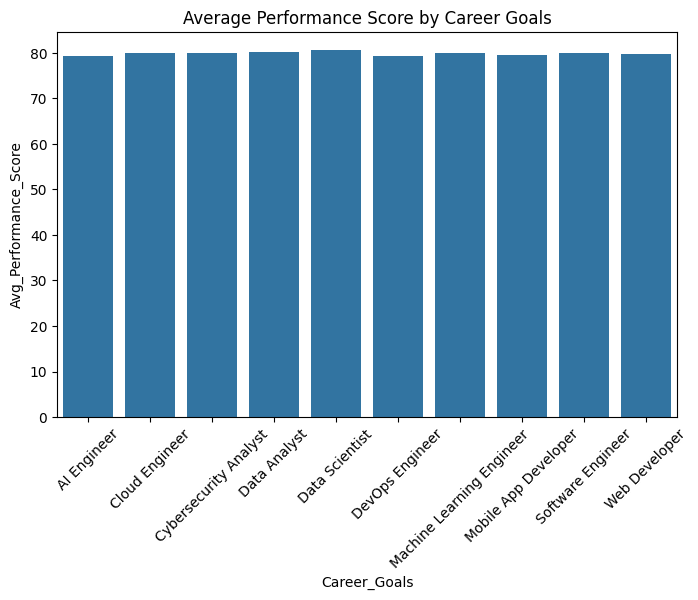

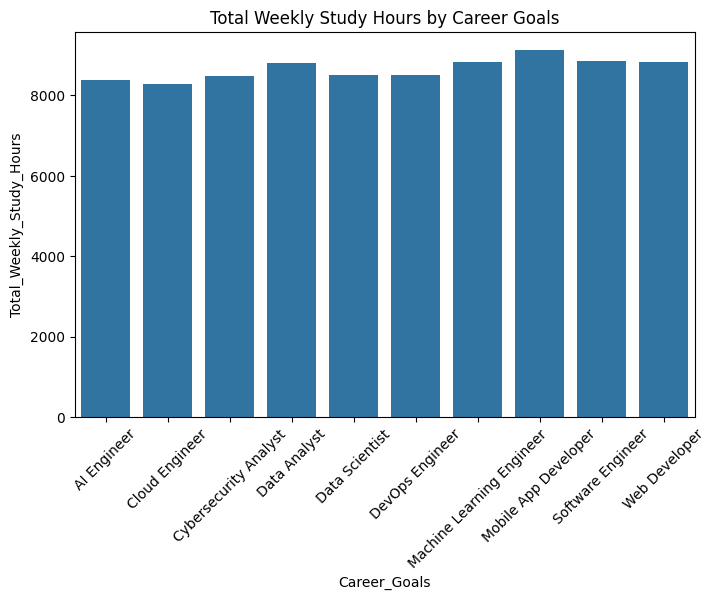

In [4]:
# Step 2: Data Aggregation
# Group by Career_Goals and calculate aggregates such as average performance score, course rating, and weekly study hours.
aggregation_df = df.groupby('Career_Goals').agg({
    'Performance_Scores': 'mean',
    'Course_Ratings': 'mean',
    'Weekly_Study_Hours': ['mean', 'sum'],
    'Engagement_Level': 'count'  # Counting the number of students per career goal
}).reset_index()

# Renaming columns for clarity
aggregation_df.columns = [
    'Career_Goals', 
    'Avg_Performance_Score', 
    'Avg_Course_Rating', 
    'Avg_Weekly_Study_Hours', 
    'Total_Weekly_Study_Hours', 
    'Student_Count'
]
# Display the aggregated data
print("\nAggregated Data by Career Goals:")
print(aggregation_df)

# Visualizing the aggregated data for insight
plt.figure(figsize=(8, 5))
sns.barplot(x='Career_Goals', y='Avg_Performance_Score', data=aggregation_df)
plt.title('Average Performance Score by Career Goals')
plt.xticks(rotation=45)
plt.show()

plt.figure(figsize=(8, 5))
sns.barplot(x='Career_Goals', y='Total_Weekly_Study_Hours', data=aggregation_df)
plt.title('Total Weekly Study Hours by Career Goals')
plt.xticks(rotation=45)
plt.show()

In [5]:
# Step 3: Data Discretization (Binning)
rating_bins = [0, 2, 4, 5]
rating_labels = ['low', 'medium', 'high']
df['Course_Rating_Category'] = pd.cut(df['Course_Ratings'], bins=rating_bins, labels=rating_labels)

In [6]:
# Step 4: Data Normalization/Scaling
# Scaling will be applied in the preprocessing pipeline below

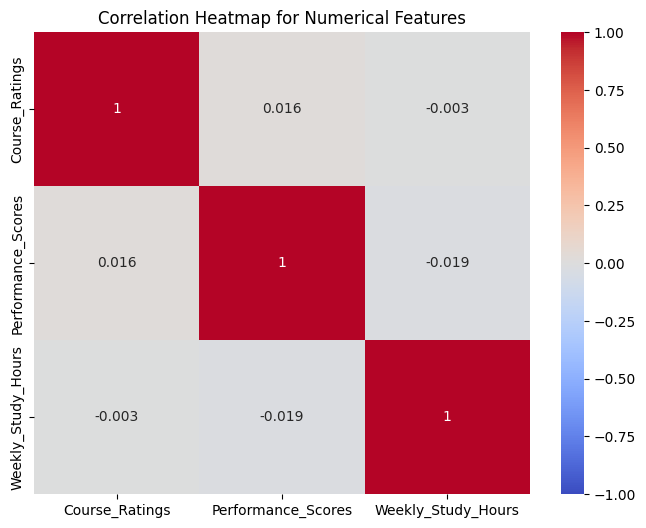

In [7]:
# Step 5: Data Reduction
# Correlation analysis
correlation_matrix = df[['Course_Ratings', 'Performance_Scores', 'Weekly_Study_Hours']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title("Correlation Heatmap for Numerical Features")
plt.show()

# Drop columns based on correlation threshold (e.g., 0.9)
highly_correlated_features = [col for col in correlation_matrix.columns if any(abs(correlation_matrix[col]) > 0.9)]
df = df.drop(columns=highly_correlated_features)

# PCA for dimensionality reduction
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
pca = PCA(n_components=2)
df_pca = pd.DataFrame(pca.fit_transform(df[numerical_columns]), columns=['PCA1', 'PCA2'])

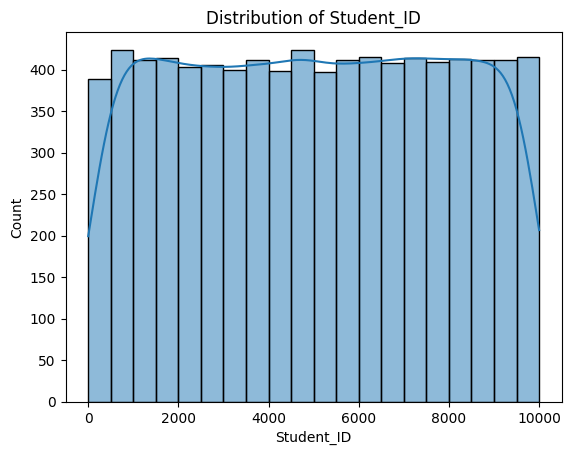

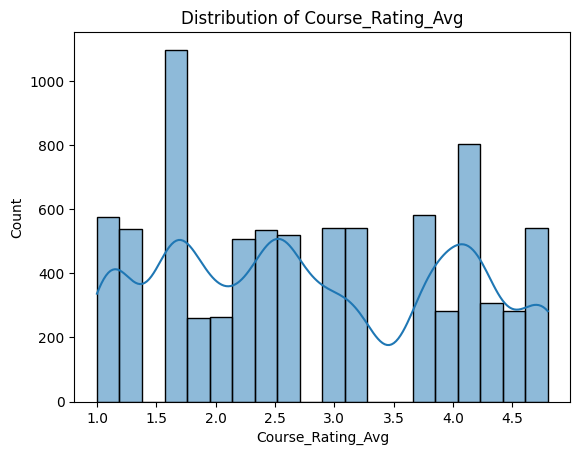

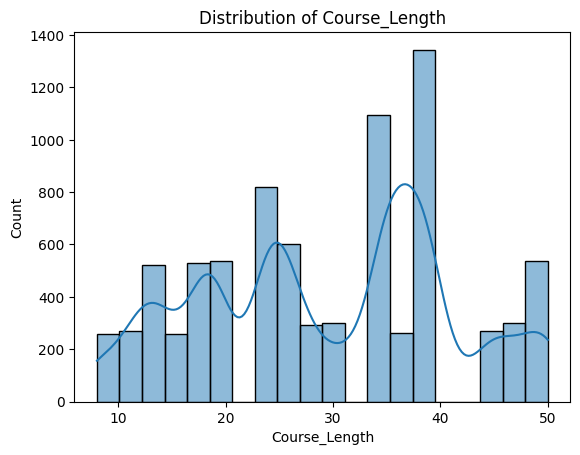

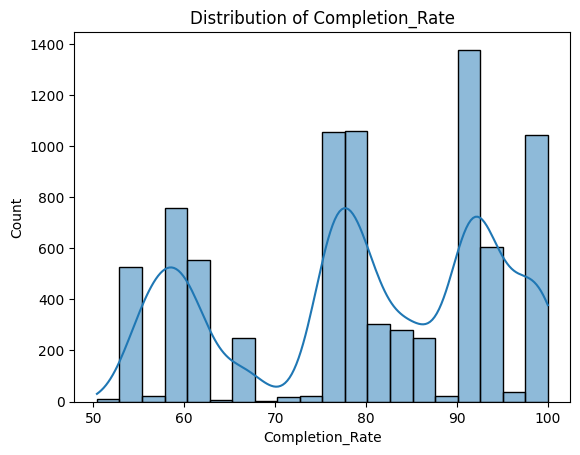

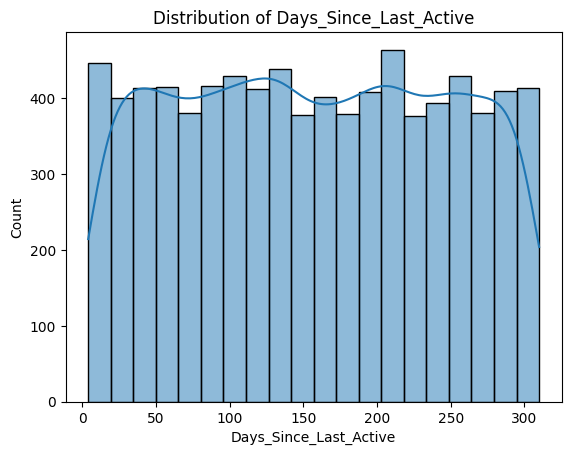

In [8]:
# Step 6: Data Visualization
# Histograms and count plots
for col in numerical_columns:
    plt.figure()
    sns.histplot(df[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
    plt.show()

In [9]:
# Step 7: Encoding Categorical Features
# MultiLabelBinarizer for multi-value columns
mlb = MultiLabelBinarizer()
skills_encoded = pd.DataFrame(mlb.fit_transform(df['Current_Skills']), columns=mlb.classes_, index=df.index)
df = df.drop(columns=['Current_Skills']).join(skills_encoded)

# One-hot encoding for categorical features
df = pd.get_dummies(df, columns=['Preferred_Learning_Style', 'Engagement_Level', 'Course_Type'], drop_first=True)

# Ordinal encoding for 'Career_Goals'
career_goal_encoder = OrdinalEncoder()
df['Career_Goals'] = career_goal_encoder.fit_transform(df[['Career_Goals']])


In [10]:
# Step 8: Define Features and Target
X = df.drop(columns=['Recommended_Course', 'Pathway_Steps', 'Course_Rating_Category'])
y = df['Recommended_Course']

In [11]:
# Step 9: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# Step 10: Preprocessing Pipeline
# Identify categorical and numerical columns
categorical_features = X_train.select_dtypes(include=['object']).columns
numerical_features = X_train.select_dtypes(exclude=['object']).columns

# Define the preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)

In [13]:
# Step 11: Model Building and Hyperparameter Tuning
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_grid = {
    'classifier__n_estimators': [50, 100, 200],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Best model
best_model = grid_search.best_estimator_
print("Best Hyperparameters:", grid_search.best_params_)


Best Hyperparameters: {'classifier__max_depth': 30, 'classifier__min_samples_split': 5, 'classifier__n_estimators': 50}


Model Accuracy: 0.8393402565668907
Classification Report:
                                                            precision    recall  f1-score   support

                    API Development with Flask (Coursera)       0.83      0.74      0.78        46
                            Algorithms, Part I (Coursera)       0.85      1.00      0.92        40
                            Ansible for Beginners (Udemy)       1.00      0.00      0.00         2
                     Automated Testing for Mobile (Udemy)       1.00      0.00      0.00         7
                           CSS Fundamentals (Pluralsight)       0.76      0.90      0.82        52
                         Cloud Security Basics (Coursera)       1.00      0.00      0.00         3
                                Computer Networking (edX)       0.86      1.00      0.92        80
Continuous Integration and Continuous Delivery (Coursera)       0.79      0.90      0.84        49
                        Cyber Incident Response (

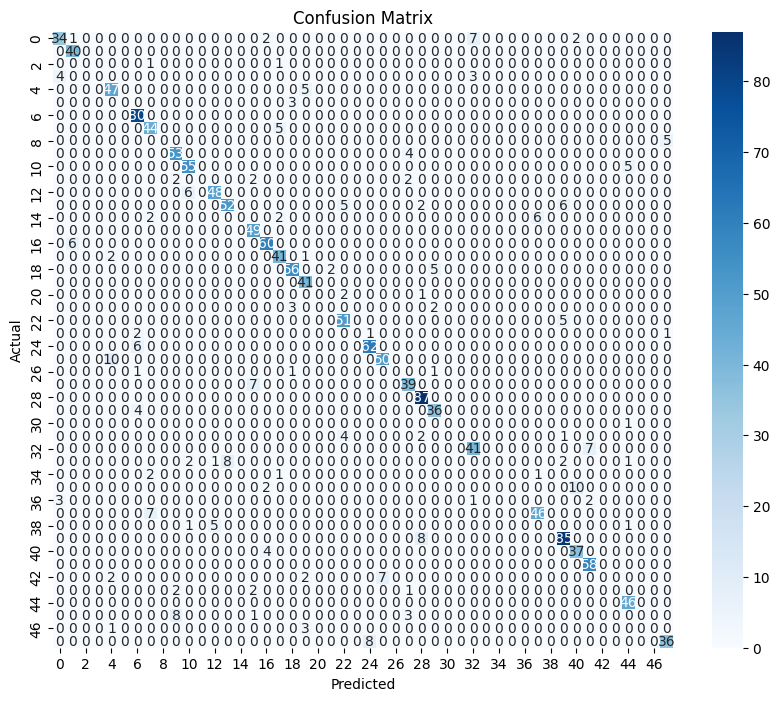

In [14]:
# Step 12: Model Evaluation
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred, zero_division=1))

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

Length of feature_importance: 401
Length of feature_names: 401


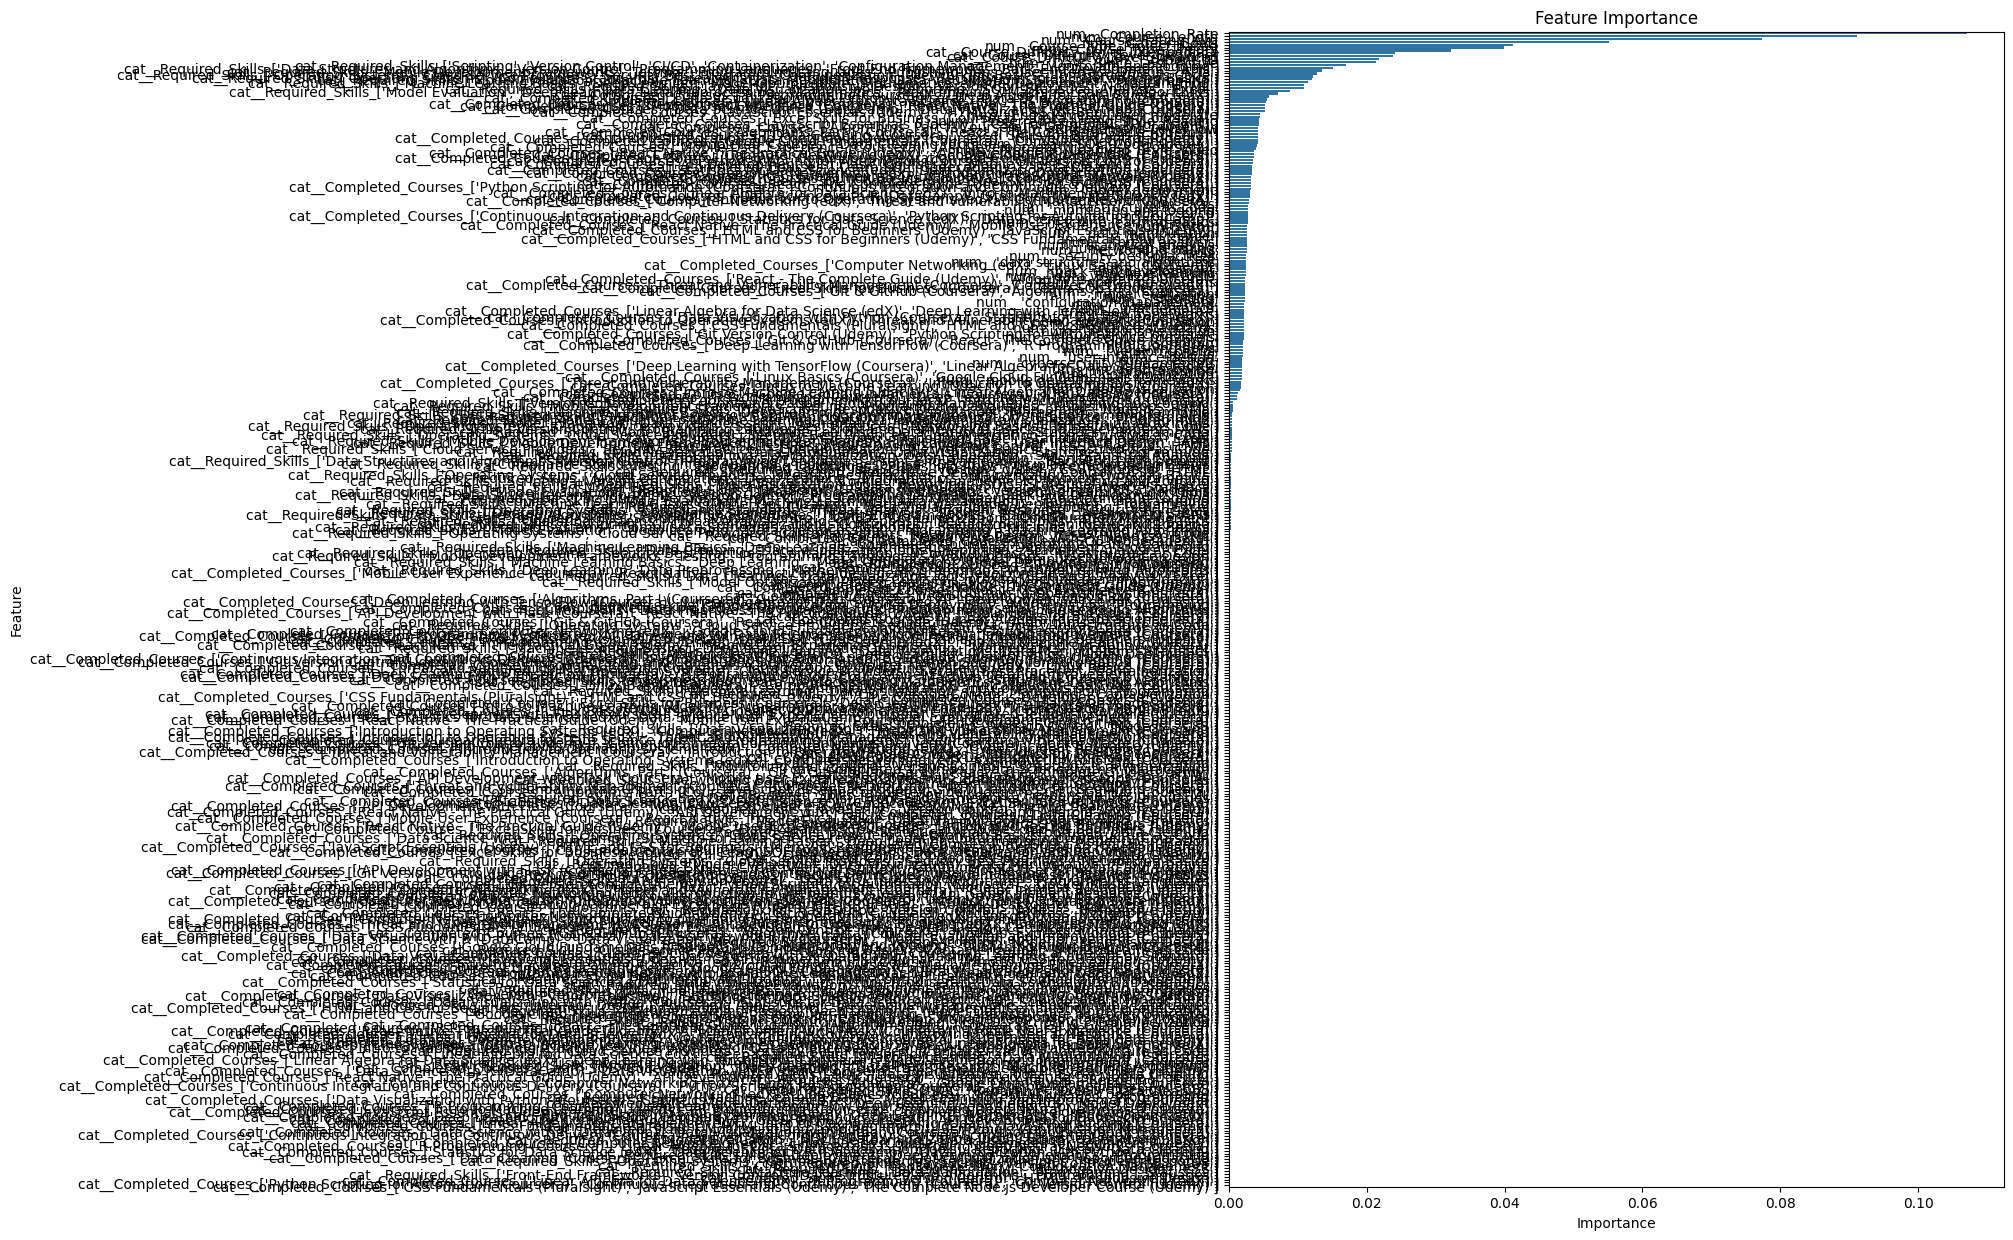

In [15]:
# Feature Importance
feature_importance = best_model.named_steps['classifier'].feature_importances_
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()
print(f"Length of feature_importance: {len(feature_importance)}")
print(f"Length of feature_names: {len(feature_names)}")

importance_df = pd.DataFrame({
    'Feature': feature_names[:len(feature_importance)],
    'Importance': feature_importance
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 15))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Feature Importance")
plt.show()